Calculating genome-wide contact insulation


In [4]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                         "please check your cooltools version and update to the latest")
import cooltools

In [6]:
resolution = 20000  # 20kb resolution
clr = cooler.Cooler('/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250708_PnMs_merged.filtCisTrans.ImportantChrom.cool')
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:fallback to serial implementation.


INFO:root:Processing region 2L_mat
INFO:root:Processing region 2L_pat
INFO:root:Processing region 2L_trans
INFO:root:Processing region 2R_mat
INFO:root:Processing region 2R_pat
INFO:root:Processing region 2R_trans
INFO:root:Processing region 3L_mat
INFO:root:Processing region 3L_pat
INFO:root:Processing region 3L_trans
INFO:root:Processing region 3R_mat
INFO:root:Processing region 3R_pat
INFO:root:Processing region 3R_trans


In [7]:
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]

insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)].iloc[1000:1005]


,chrom,start,end,region,is_bad_bin,log2_insulation_score_500000,n_valid_pixels_500000,boundary_strength_500000,is_boundary_500000
1000,2L_mat,20000000,20020000,2L_mat,False,0.335219,526.0,NaN,False
1001,2L_mat,20020000,20040000,2L_mat,False,0.177605,526.0,NaN,False
1002,2L_mat,20040000,20060000,2L_mat,False,0.015615,526.0,NaN,False
1003,2L_mat,20060000,20080000,2L_mat,False,-0.087257,526.0,NaN,False
1004,2L_mat,20080000,20100000,2L_mat,False,-0.212521,526.0,NaN,False


In [9]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

(10500000.0, 15900000.0)

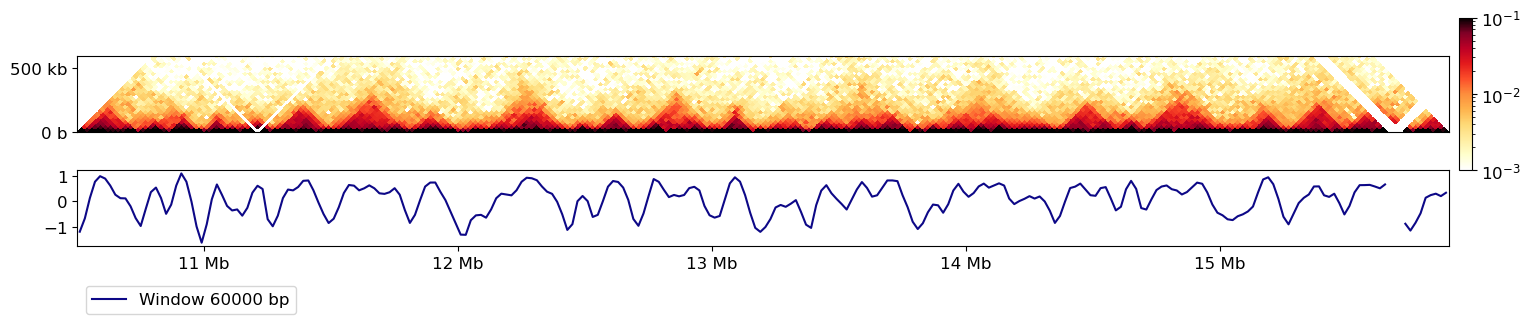

In [10]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('2L_mat', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

Adding 2L_mat and 2L_trans

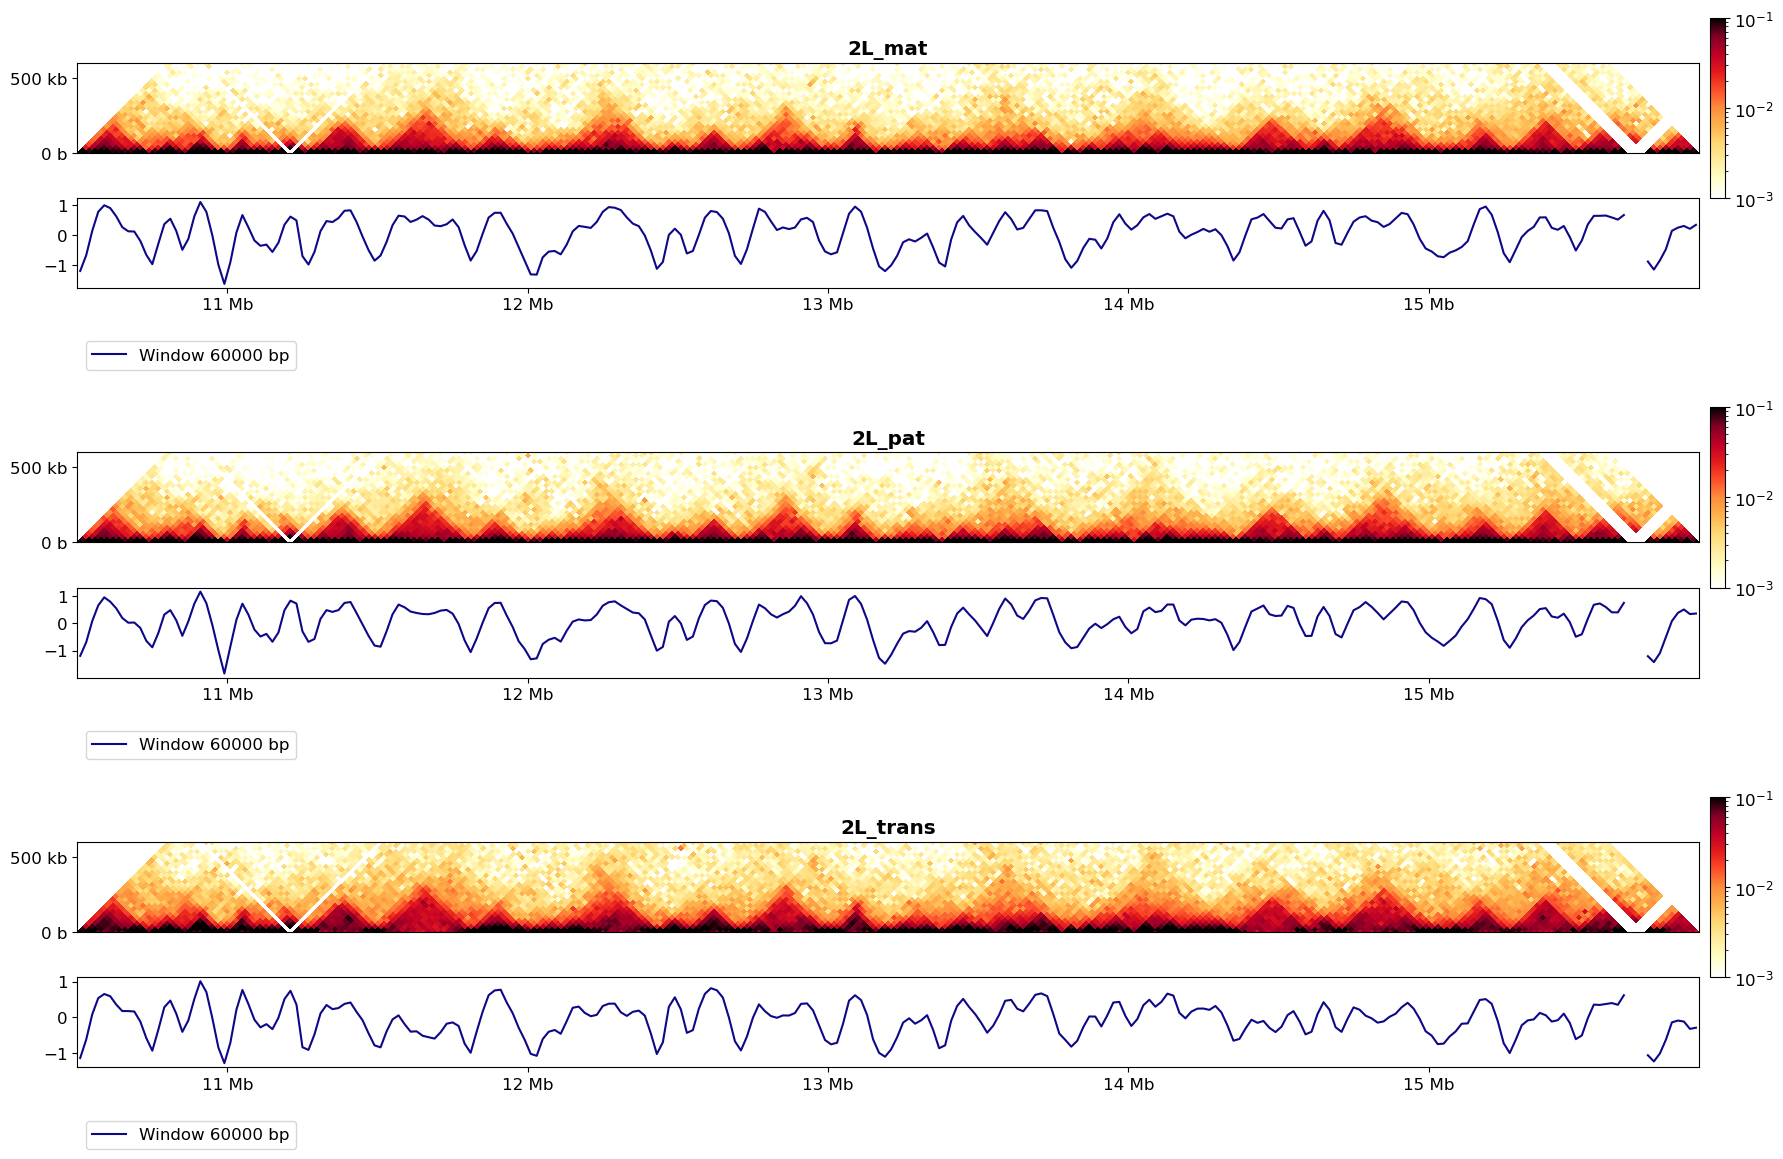

In [13]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

plt.rcParams['font.size'] = 12

regions = ['2L_mat', '2L_pat', '2L_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)

fig, axs = plt.subplots(3, 1, figsize=(18, 12), sharex=True)  # 3 vertical panels

for ax, chrom in zip(axs, regions):
    region = (chrom, *region_coords)

    # Hi-C matrix
    data = clr.matrix(balance=True).fetch(region)
    im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 10 * windows[0])
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_title(chrom, fontweight='bold')

    # Add colorbar and insulation track using axes divider
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
    plt.colorbar(im, cax=cax)

    # Plot insulation score
    insul_region = bioframe.select(insulation_table, region)
    ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
    ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0, 1, 5))))
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region['log2_insulation_score_' + str(windows[0])],
        label=f'Window {windows[0]} bp'
    )
    ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4)
    format_ticks(ins_ax, y=False, rotate=False)
    ax.set_xlim(start, end)

plt.tight_layout()
plt.show()

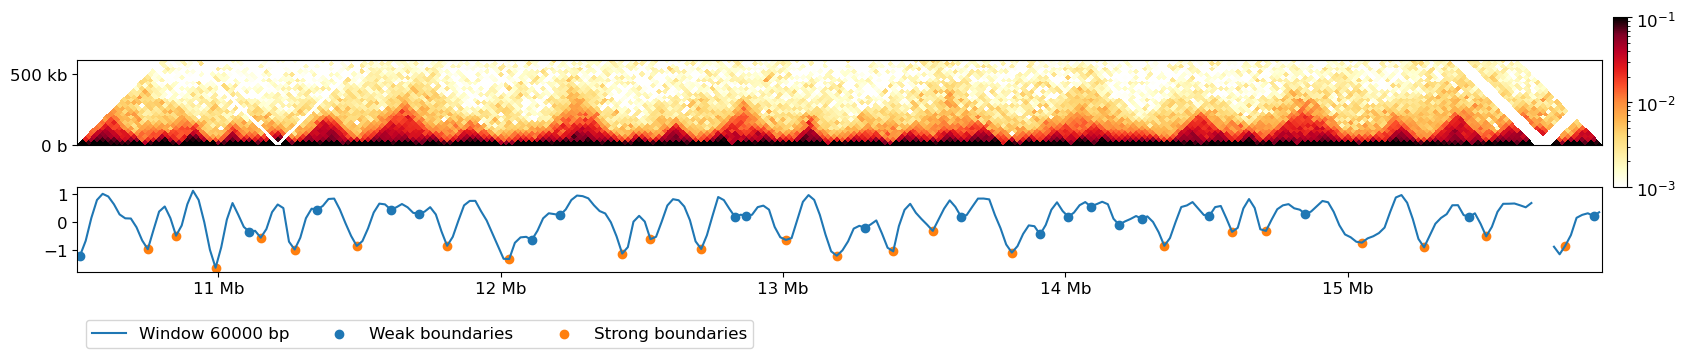

In [14]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
f

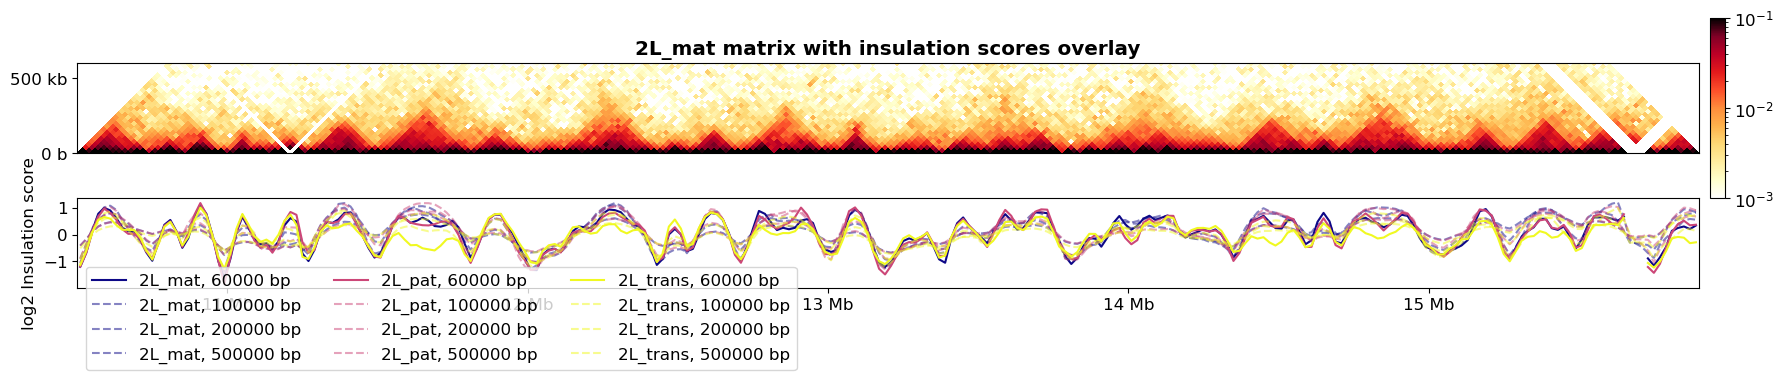

In [23]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

plt.rcParams['font.size'] = 12

regions = ['2L_mat', '2L_pat', '2L_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)

fig, ax = plt.subplots(figsize=(18, 6))

# Pick one matrix for the main plot (e.g., 2L_mat)
region = ('2L_mat', *region_coords)
data = clr.matrix(balance=True).fetch(region)
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10 * windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)
ax.set_xlim(start, end)
ax.set_title("2L_mat matrix with insulation scores overlay", fontweight='bold')

# Add colorbar and shared insulation axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
colors = plt.cm.plasma(np.linspace(0, 1, len(regions)))

# Loop over all chromosomes and plot insulation scores
for chrom, color in zip(regions, colors):
    region = (chrom, *region_coords)
    insul_region = bioframe.select(insulation_table, region)

    # Plot primary window
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{windows[0]}'],
        label=f"{chrom}, {windows[0]} bp",
        color=color
    )

    # Optional: plot additional resolutions
    for res in windows[1:]:
        ins_ax.plot(
            insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{res}'],
            linestyle='--',
            label=f"{chrom}, {res} bp",
            color=color,
            alpha=0.5
        )

# Final touches
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=3)
format_ticks(ins_ax, y=False, rotate=False)
ins_ax.set_ylabel("log2 Insulation score")
plt.tight_layout()
plt.show()

/tmp/ipykernel_688248/2058102440.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


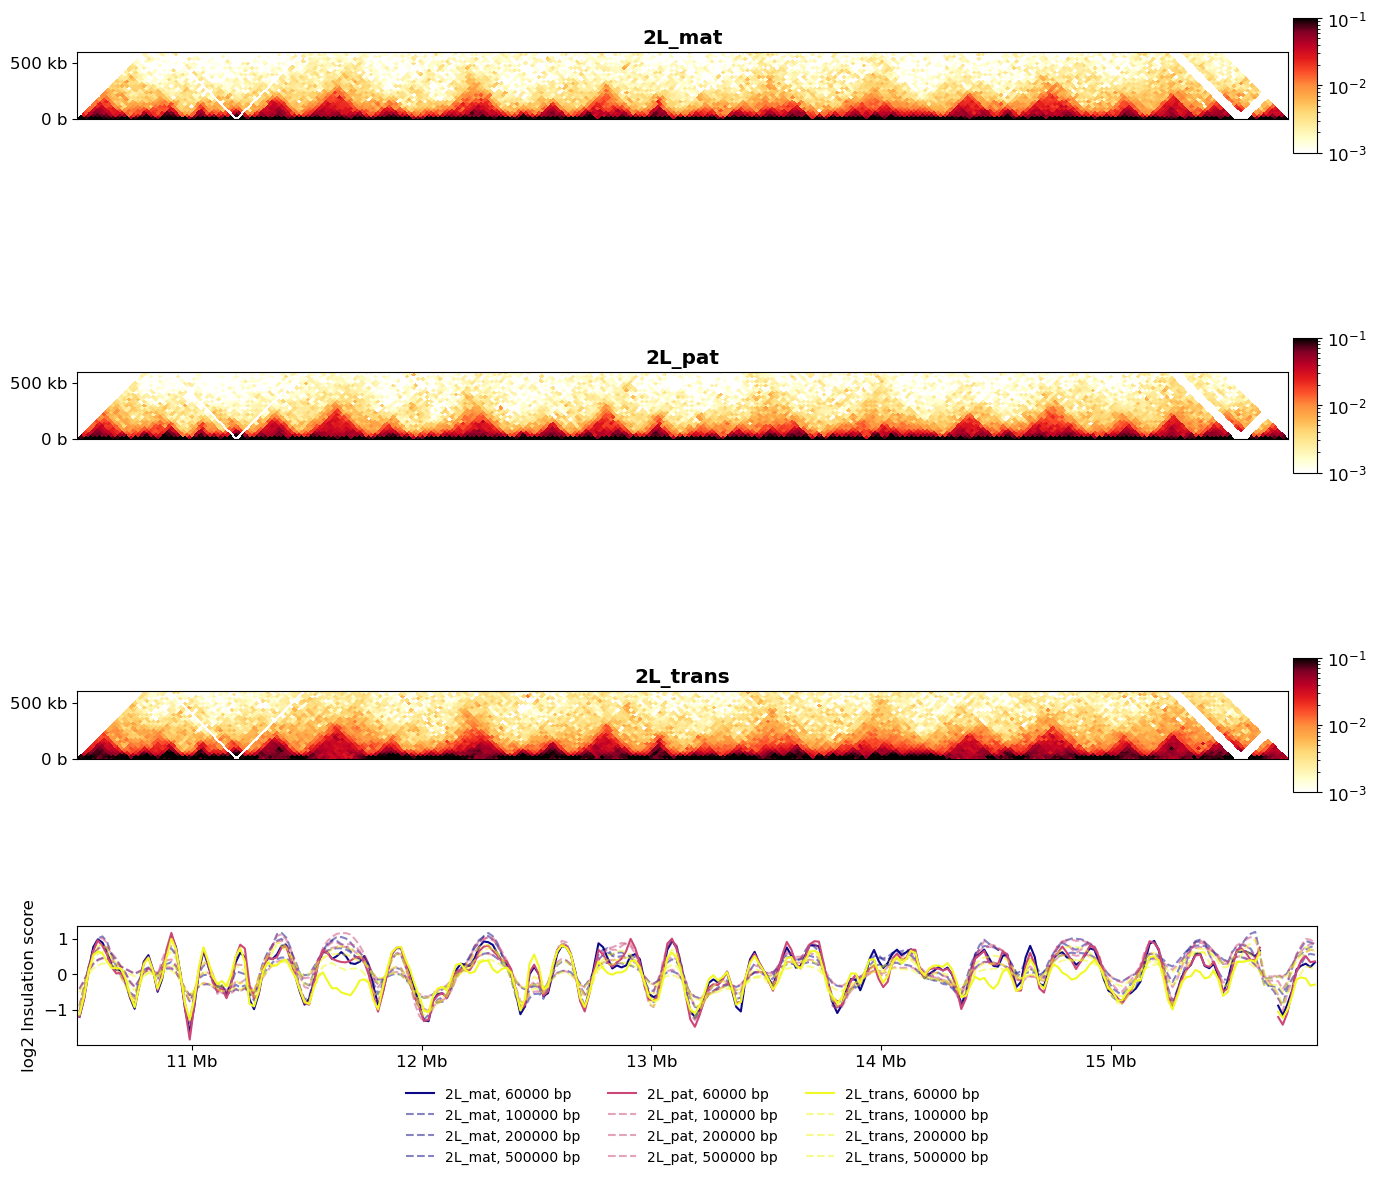

In [27]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 12

# Define regions and constants
regions = ['2L_mat', '2L_pat', '2L_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
colors = plt.cm.plasma(np.linspace(0, 1, len(regions)))

# Set up figure: 3 matrix rows + 1 insulation row = 4 rows total
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 2, 2, 1], hspace=0.4)

# Plot contact maps in 3 rows
for i, chrom in enumerate(regions):
    ax = fig.add_subplot(gs[i, 0])
    region = (chrom, *region_coords)
    data = clr.matrix(balance=True).fetch(region)

    im = pcolormesh_45deg(ax, data, start=start, resolution=resolution, norm=norm, cmap='fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 10 * windows[0])
    ax.set_xlim(start, end)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_title(f"{chrom}", fontweight='bold')

    # Add colorbar to the right of each contact map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Shared insulation score plot at the bottom
ins_ax = fig.add_subplot(gs[3, 0])

for chrom, color in zip(regions, colors):
    region = (chrom, *region_coords)
    insul_region = bioframe.select(insulation_table, region)

    # Plot main window
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{windows[0]}'],
        label=f"{chrom}, {windows[0]} bp",
        color=color
    )

    # Optional: plot additional resolutions
    for res in windows[1:]:
        ins_ax.plot(
            insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{res}'],
            linestyle='--',
            label=f"{chrom}, {res} bp",
            color=color,
            alpha=0.5
        )

format_ticks(ins_ax, y=False, rotate=False)
ins_ax.set_ylabel("log2 Insulation score")
ins_ax.set_xlim(start, end)
#ins_ax.legend(bbox_to_anchor=(0., -0.3), loc='lower left', ncol=3)

ins_ax.legend(
    bbox_to_anchor=(0.5, -0.25),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


2R

/tmp/ipykernel_688248/1501669833.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


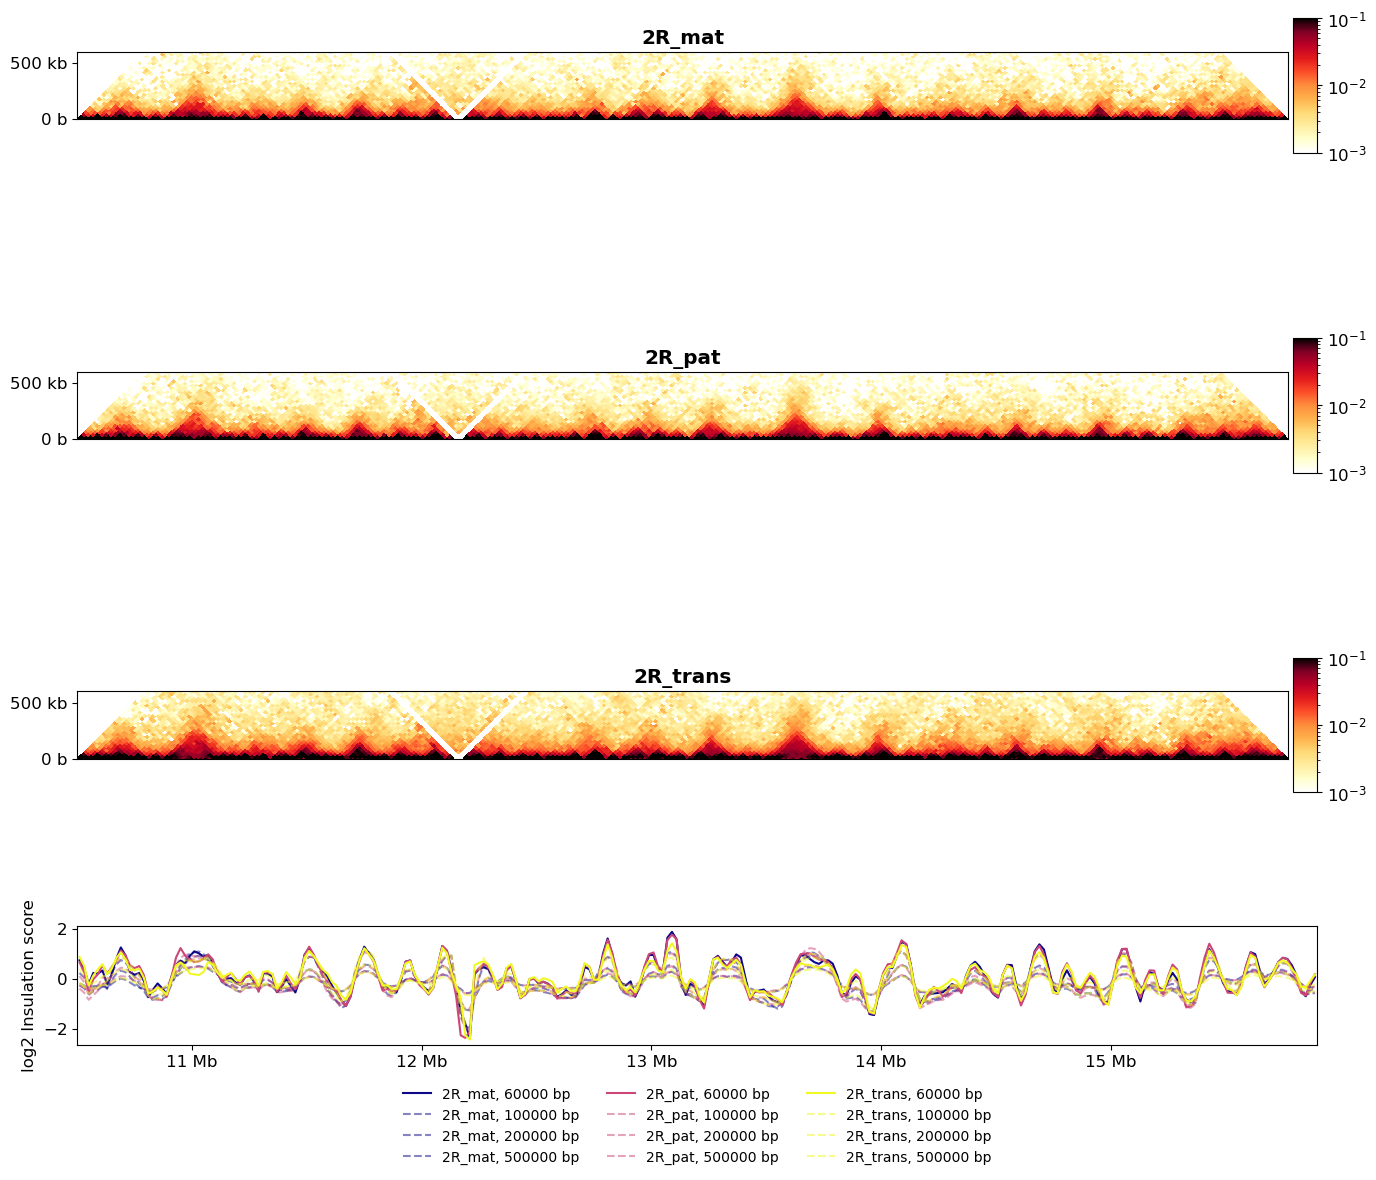

In [28]:
plt.rcParams['font.size'] = 12

# Define regions and constants
regions = ['2R_mat', '2R_pat', '2R_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
colors = plt.cm.plasma(np.linspace(0, 1, len(regions)))

# Set up figure: 3 matrix rows + 1 insulation row = 4 rows total
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 2, 2, 1], hspace=0.4)

# Plot contact maps in 3 rows
for i, chrom in enumerate(regions):
    ax = fig.add_subplot(gs[i, 0])
    region = (chrom, *region_coords)
    data = clr.matrix(balance=True).fetch(region)

    im = pcolormesh_45deg(ax, data, start=start, resolution=resolution, norm=norm, cmap='fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 10 * windows[0])
    ax.set_xlim(start, end)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_title(f"{chrom}", fontweight='bold')

    # Add colorbar to the right of each contact map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Shared insulation score plot at the bottom
ins_ax = fig.add_subplot(gs[3, 0])

for chrom, color in zip(regions, colors):
    region = (chrom, *region_coords)
    insul_region = bioframe.select(insulation_table, region)

    # Plot main window
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{windows[0]}'],
        label=f"{chrom}, {windows[0]} bp",
        color=color
    )

    # Optional: plot additional resolutions
    for res in windows[1:]:
        ins_ax.plot(
            insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{res}'],
            linestyle='--',
            label=f"{chrom}, {res} bp",
            color=color,
            alpha=0.5
        )

format_ticks(ins_ax, y=False, rotate=False)
ins_ax.set_ylabel("log2 Insulation score")
ins_ax.set_xlim(start, end)
#ins_ax.legend(bbox_to_anchor=(0., -0.3), loc='lower left', ncol=3)

ins_ax.legend(
    bbox_to_anchor=(0.5, -0.25),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


3L

/tmp/ipykernel_688248/1078859862.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


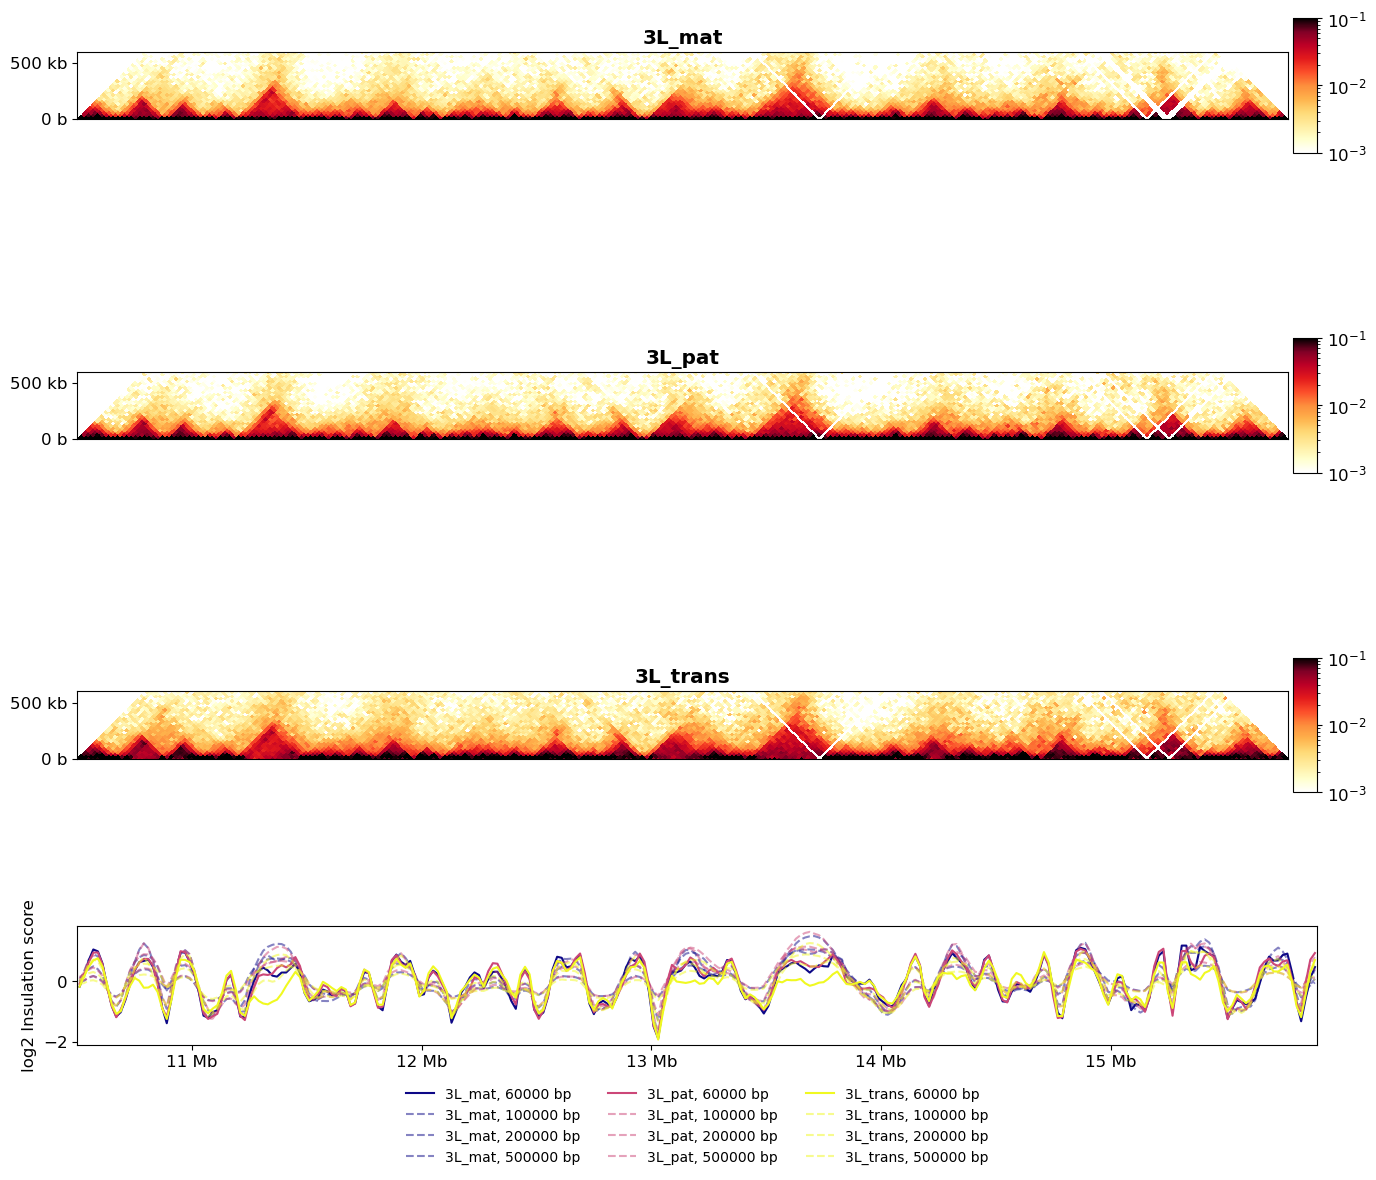

In [29]:
plt.rcParams['font.size'] = 12

# Define regions and constants
regions = ['3L_mat', '3L_pat', '3L_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
colors = plt.cm.plasma(np.linspace(0, 1, len(regions)))

# Set up figure: 3 matrix rows + 1 insulation row = 4 rows total
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 2, 2, 1], hspace=0.4)

# Plot contact maps in 3 rows
for i, chrom in enumerate(regions):
    ax = fig.add_subplot(gs[i, 0])
    region = (chrom, *region_coords)
    data = clr.matrix(balance=True).fetch(region)

    im = pcolormesh_45deg(ax, data, start=start, resolution=resolution, norm=norm, cmap='fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 10 * windows[0])
    ax.set_xlim(start, end)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_title(f"{chrom}", fontweight='bold')

    # Add colorbar to the right of each contact map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Shared insulation score plot at the bottom
ins_ax = fig.add_subplot(gs[3, 0])

for chrom, color in zip(regions, colors):
    region = (chrom, *region_coords)
    insul_region = bioframe.select(insulation_table, region)

    # Plot main window
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{windows[0]}'],
        label=f"{chrom}, {windows[0]} bp",
        color=color
    )

    # Optional: plot additional resolutions
    for res in windows[1:]:
        ins_ax.plot(
            insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{res}'],
            linestyle='--',
            label=f"{chrom}, {res} bp",
            color=color,
            alpha=0.5
        )

format_ticks(ins_ax, y=False, rotate=False)
ins_ax.set_ylabel("log2 Insulation score")
ins_ax.set_xlim(start, end)
#ins_ax.legend(bbox_to_anchor=(0., -0.3), loc='lower left', ncol=3)

ins_ax.legend(
    bbox_to_anchor=(0.5, -0.25),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


3R

/tmp/ipykernel_688248/1263100002.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


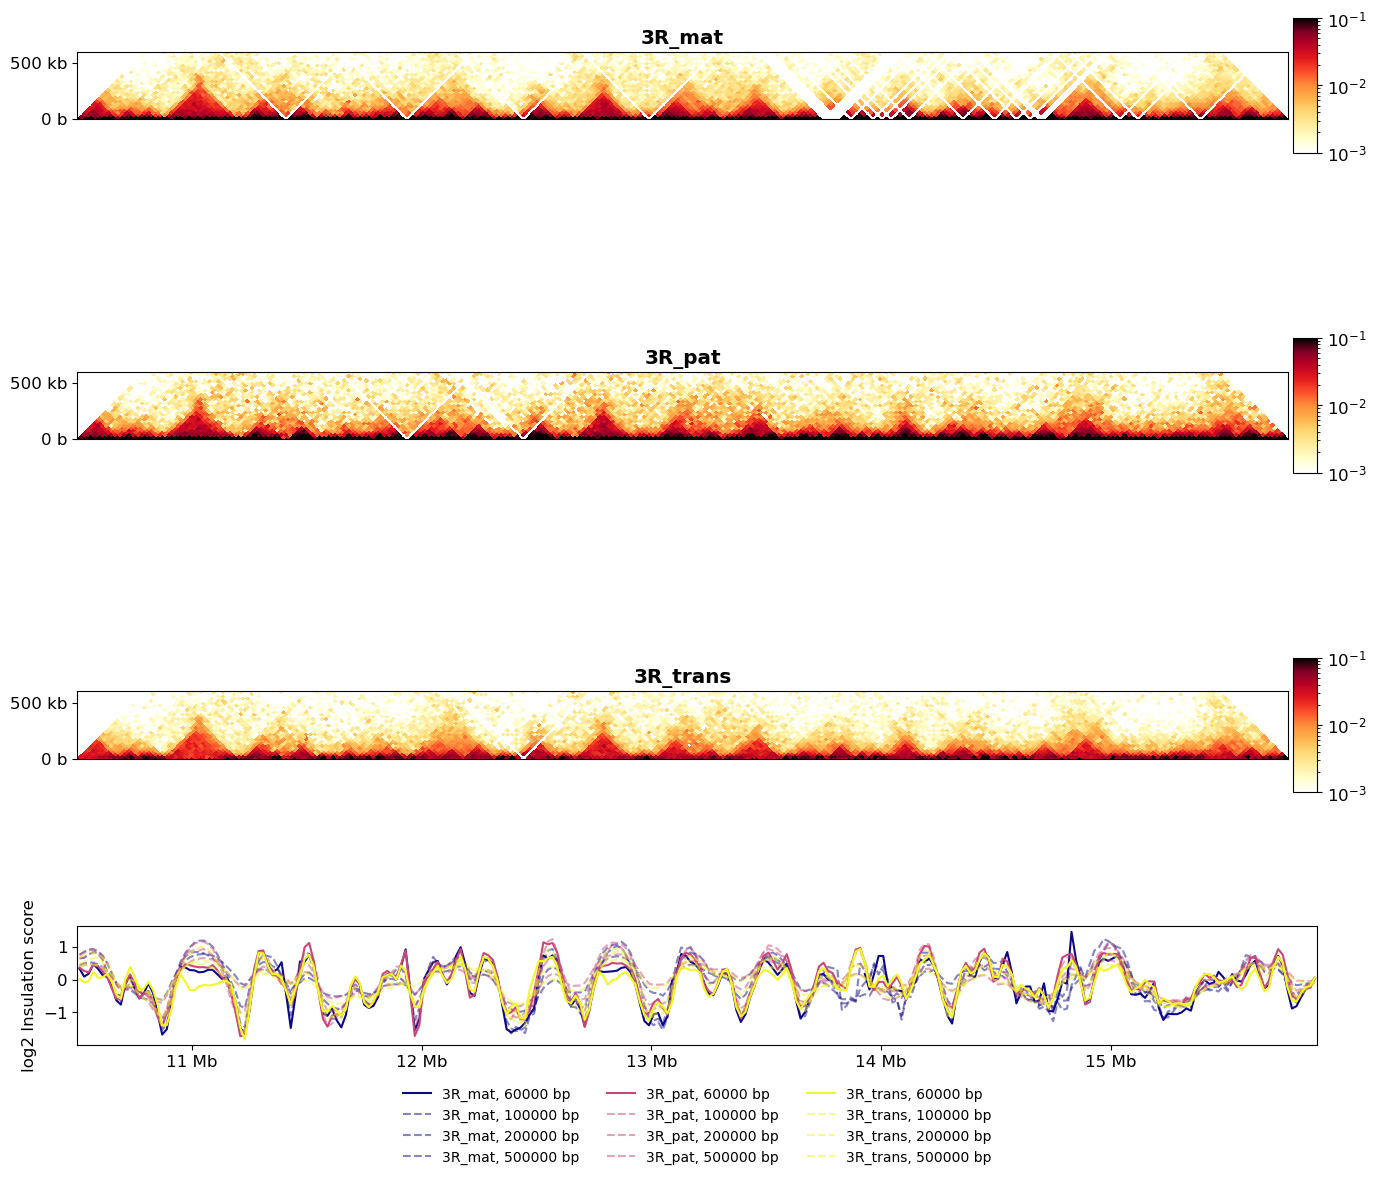

In [30]:
plt.rcParams['font.size'] = 12

# Define regions and constants
regions = ['3R_mat', '3R_pat', '3R_trans']
start = 10_500_000
end = start + 90 * windows[0]
region_coords = (start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
colors = plt.cm.plasma(np.linspace(0, 1, len(regions)))

# Set up figure: 3 matrix rows + 1 insulation row = 4 rows total
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 2, 2, 1], hspace=0.4)

# Plot contact maps in 3 rows
for i, chrom in enumerate(regions):
    ax = fig.add_subplot(gs[i, 0])
    region = (chrom, *region_coords)
    data = clr.matrix(balance=True).fetch(region)

    im = pcolormesh_45deg(ax, data, start=start, resolution=resolution, norm=norm, cmap='fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 10 * windows[0])
    ax.set_xlim(start, end)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_title(f"{chrom}", fontweight='bold')

    # Add colorbar to the right of each contact map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Shared insulation score plot at the bottom
ins_ax = fig.add_subplot(gs[3, 0])

for chrom, color in zip(regions, colors):
    region = (chrom, *region_coords)
    insul_region = bioframe.select(insulation_table, region)

    # Plot main window
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{windows[0]}'],
        label=f"{chrom}, {windows[0]} bp",
        color=color
    )

    # Optional: plot additional resolutions
    for res in windows[1:]:
        ins_ax.plot(
            insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{res}'],
            linestyle='--',
            label=f"{chrom}, {res} bp",
            color=color,
            alpha=0.5
        )

format_ticks(ins_ax, y=False, rotate=False)
ins_ax.set_ylabel("log2 Insulation score")
ins_ax.set_xlim(start, end)
#ins_ax.legend(bbox_to_anchor=(0., -0.3), loc='lower left', ncol=3)

ins_ax.legend(
    bbox_to_anchor=(0.5, -0.25),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()

Let’s repeat the previous plot and show where we found the boundaries:

(10500000.0, 15900000.0)

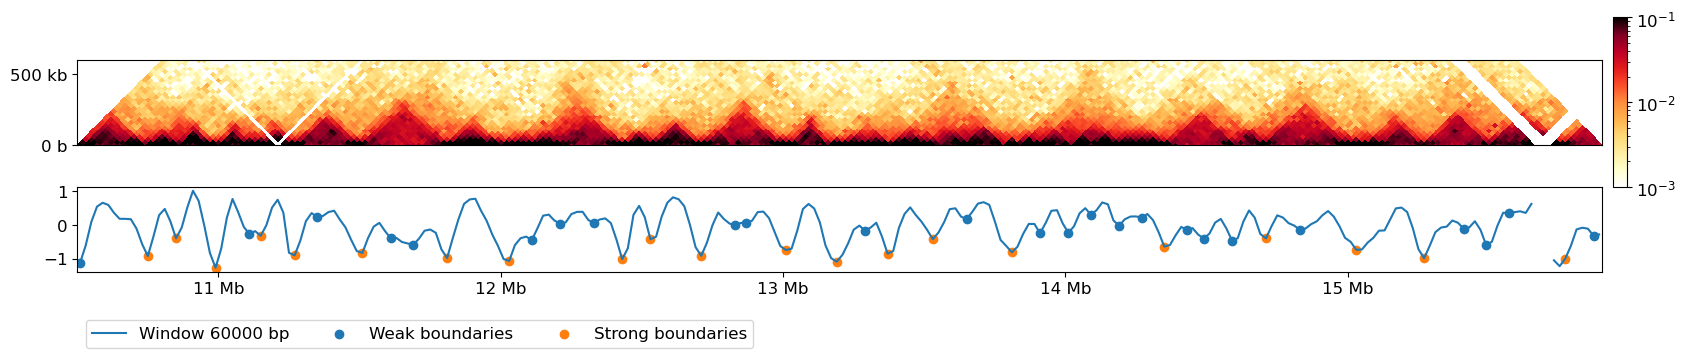

In [15]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])


Calculating boundary strenght

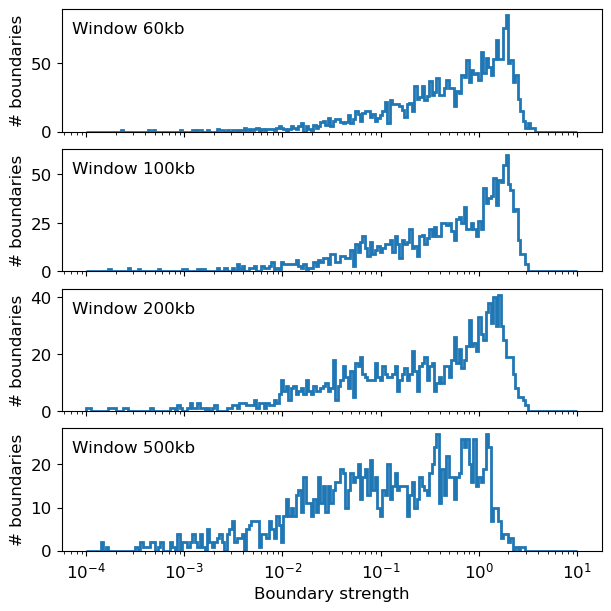

In [16]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(6,6), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    ax.text(0.02, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength');

[Text(0.5, 0, 'Boundary strength')]

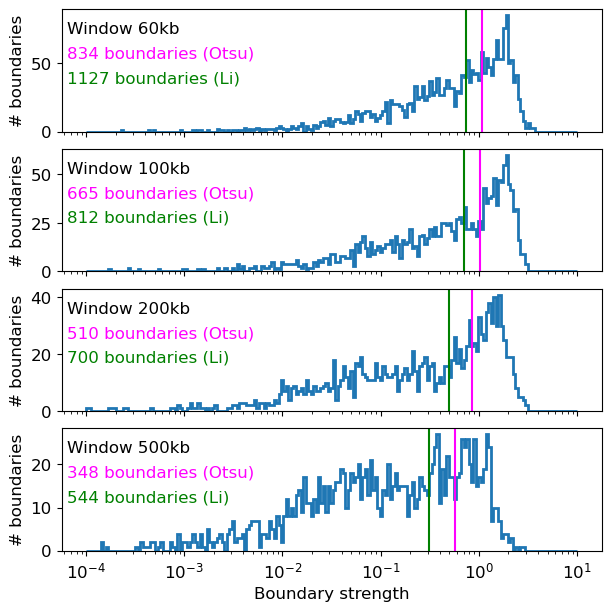

In [17]:
from skimage.filters import threshold_li, threshold_otsu

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength')

Εxtract TADs

In [20]:
def extract_TADs(insulation_table, is_boundary_col, max_TAD_length = 3000000):
    tads = bioframe.merge(insulation_table[insulation_table[is_boundary_col] == False])
    return tads[ (tads["end"] - tads["start"]) <= max_TAD_length].reset_index(drop=True)[['chrom','start','end']]

TADs_table = extract_TADs(insulation_table, f'is_boundary_{windows[0]}')
TADs_table.head()

,chrom,start,end
0,2L_mat,0,120000
1,2L_mat,140000,560000
2,2L_mat,580000,840000
3,2L_mat,860000,1160000
4,2L_mat,1180000,1380000


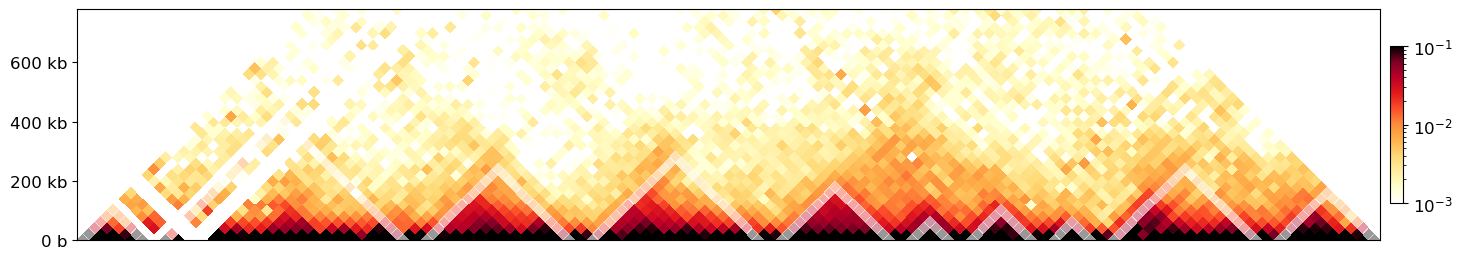

In [22]:
# Visualizing the first 10 inter-boundary intervals (grey overay) v.s. Hi-C data

region = ('2L_mat', TADs_table.iloc[0].start, TADs_table.iloc[9].end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 13*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

idx = 10
max_pos = TADs_table[:idx]['end'].max()/resolution
contact_matrix = np.zeros((int(max_pos), int(max_pos)))
contact_matrix[:] = np.nan
for _, row in TADs_table[:idx].iterrows():
    contact_matrix[int(row['start']/resolution):int(row['end']/resolution), int(row['start']/resolution):int(row['end']/resolution)] = 1
    contact_matrix[int(row['start']/resolution + 1):int(row['end']/resolution - 1), int(row['start']/resolution + 1):int(row['end']/resolution - 1)] = np.nan

im = pcolormesh_45deg(ax, contact_matrix, start=0, resolution=resolution, cmap='gray', vmax=1, vmin=-1, alpha=0.6)

plt.show()